In [1]:
import math, random
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import torch.nn.functional as F
from torch.distributions import Categorical

In [2]:
torch.manual_seed(51)

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

# Retrieve data from Quandl

Don't bother with this step if the data's already saved from the Pickle below.

In [4]:
import quandl
#quandl.ApiConfig.api_key = "xxx"
apl_stock=quandl.get('WIKI/AAPL', start_date="2014-01-01", end_date="2018-08-20", )
msf_stock=quandl.get('WIKI/MSFT', start_date="2014-01-01", end_date="2018-08-20")

In [5]:
apl_open = apl_stock["Adj. Open"].values
apl_close = apl_stock["Adj. Close"].values
msf_open = msf_stock["Adj. Open"].values
msf_close = msf_stock["Adj. Close"].values

In [6]:
msf_stock.head()

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
2014-01-02,37.350,37.40,37.10,37.16,30632200.0,0.0,1.0,33.704254,33.749373,33.478656,33.532800,30632200.0
2014-01-03,37.200,37.22,36.60,36.91,31134800.0,0.0,1.0,33.568895,33.586943,33.027461,33.307202,31134800.0
2014-01-06,36.850,36.89,36.11,36.13,43603700.0,0.0,1.0,33.253059,33.289154,32.585290,32.603338,43603700.0
2014-01-07,36.325,36.49,36.21,36.41,35802800.0,0.0,1.0,32.779304,32.928198,32.675529,32.856007,35802800.0
2014-01-08,36.000,36.14,35.58,35.76,59971700.0,0.0,1.0,32.486028,32.612362,32.107024,32.269454,59971700.0


## Examine the data

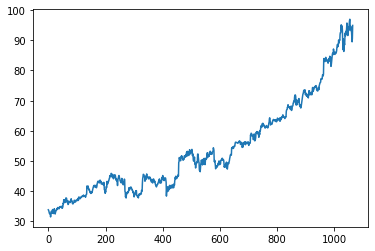

In [7]:
plt.plot(range(0, len(msf_open)), msf_open)

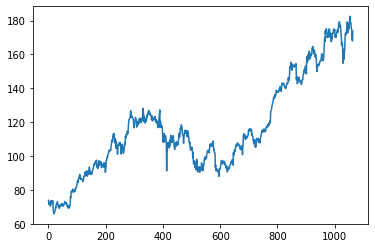

In [8]:
plt.plot(range(0, len(apl_open)), apl_open)

## Looks better, now remove the general upwards trend.

Now I'm going to de-trend the data. Otherwise MSFT and AAPL are on completely different scales and we could hardly expect the AI to learn how to trade apples and oranges together. Additionally, we want the AI to learn the fundamentals of the stock signal - buy if it's going to rise. If we didn't remove the trend, maybe it'd only learn to buy at the start and hold til the end since a general upwards trend happens.

SciPy's signal processing module has a function that fits a linear least-squares model to the data and subtracts it for us.

In [9]:
from scipy import signal

In [10]:
msf_open = signal.detrend(msf_open)
msf_close = signal.detrend(msf_close)

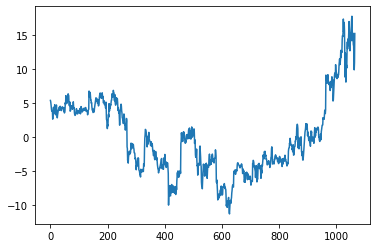

In [11]:
plt.plot(range(0,len(msf_open)), msf_open)

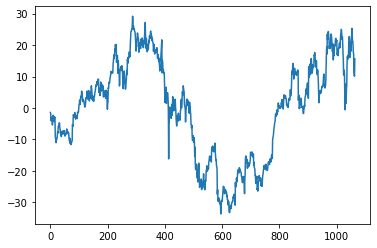

In [12]:
apl_open = signal.detrend(apl_open)
apl_close = signal.detrend(apl_close)
plt.plot(range(0, len(apl_open)), apl_open)

## Negative values?

It doesn't make sense to buy a share at a negative value. But since the model will learn to maximize reward, we can just shift it up by a constant number so it's always positive.

In [13]:
print(apl_open.min())
print(apl_close.min())
print(msf_open.min())
print(msf_close.min())

-33.65196259442547
-34.02119858364249
-11.282235770635843
-11.729290276561947


Choose 35

In [14]:
apl_open += 35.
apl_close += 35.
msf_open += 35.
msf_close += 35.

## Save the transformed data

In [15]:
import pickle
with open("aplmsfopenclose.pkl", "wb+") as f:
    pickle.dump({"ao":apl_open, "ac": apl_close, "mo": msf_open, "mc": msf_close, "as": apl_stock, "ms": msf_stock}, f)

## If the data's already saved, skip the above and load it here instead

In [4]:
import pickle
with open("aplmsfopenclose.pkl", "rb") as f:
    d = pickle.load(f)
apl_open = d["ao"]
apl_close = d["ac"]
msf_open = d["mo"]
msf_close = d["mc"]
apl_stock = d["as"]
msf_stock = d["ms"]

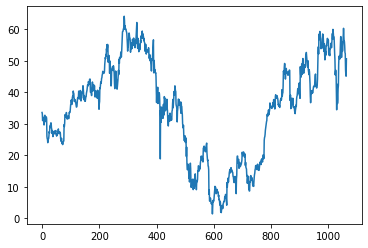

In [5]:
plt.plot(range(0,len(apl_open)), apl_open)

# Build the environment

* For starting cash, we can't use a dollar value because of the transformed data. After shifting earlier, we know the mean of each opening price should be 35, so I'm starting the agent off with enough cash to buy ~2.5 shares.
* This starting cash is the mean starting cash; it can be randomized by altering the std parameter
* action space = 0 buy apple, 1 sell apple, 2 do nothing, 3 buy msft, 4 sell msft, quantity. eg. [0, 100]
* obs space: apl shares, msft shares, cash in bank [2], today apl open [3], today msf open [4], portfolio value [5], 5 day window [6apl, 7msf] = 8
* If bot gets to the end with more than one of each share, we give it a bonus for having a diversified portfolio!
* Buys and sells attract a 10% brokerage fee

In [6]:
class TradingEnvironment():

    def __init__(self, starting_cash_mean=200., max_stride=5, series_length=208, starting_point=1, randomize_cash_std=0, \
                 starting_shares_mean=0., randomize_shares_std=0., inaction_penalty=0.):
        self.starting_shares_mean = starting_shares_mean
        self.randomize_shares_std = randomize_shares_std
        self.starting_cash_mean = starting_cash_mean
        self.randomize_cash_std = randomize_cash_std
        
        self.state = torch.FloatTensor(torch.zeros(8)).cuda()
        
        self.starting_cash = max(int(np.random.normal(self.starting_cash_mean, self.randomize_cash_std)), 0.)
        
        self.series_length = series_length
        self.starting_point = starting_point
        self.cur_timestep = self.starting_point
        
        self.state[0] = max(int(np.random.normal(self.starting_shares_mean, self.randomize_shares_std)), 0.)
        self.state[1] = max(int(np.random.normal(self.starting_shares_mean, self.randomize_shares_std)), 0.)
        self.starting_portfolio_value = self.portfolio_value()
        self.state[2] = self.starting_cash
        self.state[3] = apl_open[self.cur_timestep]
        self.state[4] = msf_open[self.cur_timestep]
        self.state[5] = self.starting_portfolio_value
        self.state[6] = self.five_day_window()[0]
        self.state[7] = self.five_day_window()[1]
        
        self.max_stride = max_stride
        self.stride = self.max_stride # no longer varying it
        
        self.done = False
        self.diversification_bonus = 1.
        self.inaction_penalty = inaction_penalty
    
    def portfolio_value(self):
        return (self.state[0] * apl_close[self.cur_timestep]) + (self.state[1] * msf_close[self.cur_timestep]) + self.state[2]
    
    def next_opening_price(self):
        step = self.cur_timestep + self.stride
        return [apl_open[step], msf_open[step]]
    
    def five_day_window(self):
        step = self.cur_timestep
        if step < 5:
            return [apl_open[0], msf_open[0]]
        apl5 = apl_open[step-5:step].mean()
        msf5 = msf_open[step-5:step].mean()
        return [apl5, msf5]
    
    def step(self, action):
        action = [action, 1.]
        cur_timestep = self.cur_timestep
        ts_left = self.series_length - (cur_timestep - self.starting_point)
        retval = None
        cur_value = self.portfolio_value()
        gain = cur_value - self.starting_portfolio_value
        
        if cur_timestep >= self.starting_point + (self.series_length * self.stride):
            new_state = [self.state[0], self.state[1], self.state[2], *self.next_opening_price(), \
                        cur_value, *self.five_day_window()]
            self.state = new_state
            bonus = 0.
            if self.state[0] > 0 and self.state[1] > 0:
                bonus = self.diversification_bonus
            return new_state, cur_value + bonus + gain, True, { "msg": "done"}
        
        if action[0] == 2:
            new_state = [self.state[0], self.state[1], self.state[2], *self.next_opening_price(), \
                    cur_value, *self.five_day_window()]
            self.state = new_state
            retval = new_state, -self.inaction_penalty-ts_left +gain, False, { "msg": "nothing" }
            
        if action[0] == 0:
            if action[1] * apl_open[cur_timestep] > self.state[2]:
                new_state = [self.state[0], self.state[1], self.state[2], *self.next_opening_price(), \
                        cur_value, *self.five_day_window()]
                self.state = new_state
                retval = new_state, -ts_left+gain/2, True, { "msg": "bankrupted self"}
            else:
                apl_shares = self.state[0] + action[1]
                cash_spent = action[1] * apl_open[cur_timestep] * 1.1
                new_state = [apl_shares, self.state[1], self.state[2] - cash_spent, *self.next_opening_price(), \
                       cur_value, *self.five_day_window()]
                self.state = new_state
                retval = new_state, self.inaction_penalty-ts_left+gain, False, { "msg": "bought AAPL"}
                
        if action[0] == 3:
            if action[1] * msf_open[cur_timestep] > self.state[2]:
                new_state = [self.state[0], self.state[1], self.state[2], *self.next_opening_price(), \
                        cur_value, *self.five_day_window()]
                self.state = new_state
                retval =  new_state, -ts_left+gain/2, True, { "msg": "bankrupted self"}
            else:
                msf_shares = self.state[1] + action[1]
                cash_spent = action[1] * msf_open[cur_timestep] * 1.1
                new_state = [self.state[0], msf_shares, self.state[2] - cash_spent, *self.next_opening_price(), \
                       cur_value, *self.five_day_window()]
                self.state = new_state
                retval = new_state, self.inaction_penalty-ts_left+gain, False, { "msg": "bought MSFT"}
        

        if action[0] == 1:
            if action[1] > self.state[0]:
                new_state = [self.state[0], self.state[1], self.state[2], *self.next_opening_price(), \
                        cur_value, *self.five_day_window()]
                self.state = new_state
                retval = new_state, -ts_left+gain/2, True, { "msg": "sold more than have"}
            else:
                apl_shares = self.state[0] - action[1]
                cash_gained = action[1] * apl_open[cur_timestep] * 0.9
                new_state = [apl_shares, self.state[1], self.state[2] + cash_gained, *self.next_opening_price(), \
                       cur_value, *self.five_day_window()]
                self.state = new_state
                retval = new_state, self.inaction_penalty-ts_left+gain, False, { "msg": "sold AAPL"}
                
        if action[0] == 4:
            if action[1] > self.state[1]:
                new_state = [self.state[0], self.state[1], self.state[2], *self.next_opening_price(), \
                        cur_value, *self.five_day_window()]
                self.state = new_state
                retval = new_state, -ts_left+gain/2, True, { "msg": "sold more than have"}
            else:
                msf_shares = self.state[1] - action[1]
                cash_gained = action[1] * msf_open[cur_timestep] * 0.9
                new_state = [self.state[0], msf_shares, self.state[2] + cash_gained, *self.next_opening_price(), \
                       cur_value, *self.five_day_window()]
                self.state = new_state
                retval = new_state, self.inaction_penalty-ts_left+gain, False, { "msg": "sold MSFT"}
                
        self.cur_timestep += self.stride
        return retval
    
    def reset(self):
        self.state = torch.FloatTensor(torch.zeros(8)).cuda()
        self.starting_cash = max(int(np.random.normal(self.starting_cash_mean, self.randomize_cash_std)), 0.)
        self.cur_timestep = self.starting_point
        self.state[0] = max(int(np.random.normal(self.starting_shares_mean, self.randomize_shares_std)), 0.)
        self.state[1] = max(int(np.random.normal(self.starting_shares_mean, self.randomize_shares_std)), 0.)
        self.state[2] = self.starting_cash
        self.state[3] = apl_open[self.cur_timestep]
        self.state[4] = msf_open[self.cur_timestep]
        self.starting_portfolio_value = self.portfolio_value()
        self.state[5] = self.starting_portfolio_value
        self.state[6] = self.five_day_window()[0]
        self.state[7] = self.five_day_window()[1]       
        self.done = False
        return self.state

In [7]:
class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        self.input_layer = nn.Linear(8, 128)
        self.hidden_1 = nn.Linear(128, 128)
        self.hidden_2 = nn.Linear(32,31)
        self.hidden_state = torch.tensor(torch.zeros(2,1,32)).cuda()
        self.rnn = nn.GRU(128, 32, 2)
        self.action_head = nn.Linear(31, 5)
        self.value_head = nn.Linear(31, 1)
        self.saved_actions = []
        self.rewards = []

    def reset_hidden(self):
        self.hidden_state = torch.tensor(torch.zeros(2,1,32)).cuda()
        
    def forward(self, x):
        x = torch.tensor(x).cuda()
        x = torch.sigmoid(self.input_layer(x))
        x = torch.tanh(self.hidden_1(x))
        x, self.hidden_state = self.rnn(x.view(1,-1,128), self.hidden_state.data)
        x = F.relu(self.hidden_2(x.squeeze()))
        action_scores = self.action_head(x)
        state_values = self.value_head(x)
        return F.softmax(action_scores, dim=-1), state_values
    
    def act(self, state):
        probs, state_value = self.forward(state)
        m = Categorical(probs)
        action = m.sample()
        if action == 1 and env.state[0] < 1: action = torch.LongTensor([2]).squeeze().cuda()
        if action == 4 and env.state[1] < 1: action = torch.LongTensor([2]).squeeze().cuda()
        self.saved_actions.append((m.log_prob(action), state_value))
        return action.item()

In [8]:
env = TradingEnvironment(max_stride=4, series_length=250, starting_cash_mean=5000, randomize_cash_std=100, starting_shares_mean=0, randomize_shares_std=0)
model = Policy().cuda()
# optimizer = optim.Adam(model.parameters(), lr=3e-4)
optimizer = optim.Adam(model.parameters(), lr=0.01)

/Users/gert/anaconda3/envs/ptc/lib/python3.6/site-packages/torch/cuda/__init__.py:131: UserWarning: 
    Found GPU0 GeForce GT 750M which is of cuda capability 3.0.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability that we support is 3.5.
    
  warnings.warn(old_gpu_warn % (d, name, major, capability[1]))
/Users/gert/anaconda3/envs/ptc/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/Users/gert/anaconda3/envs/ptc/lib/python3.6/site-packages/torch/backends/cudnn/__init__.py:115: UserWarning: PyTorch was compiled without cuDNN support. To use cuDNN, rebuild PyTorch making sure the library is visible to the build system.
  "PyTorch was compiled without cuDNN support. To use cuDNN, rebuild "


In [12]:
model.load_state_dict(torch.load('rl_13.pkl'))
model.eval()

Policy(
  (input_layer): Linear(in_features=8, out_features=128, bias=True)
  (hidden_1): Linear(in_features=128, out_features=128, bias=True)
  (hidden_2): Linear(in_features=32, out_features=31, bias=True)
  (rnn): GRU(128, 32, num_layers=2)
  (action_head): Linear(in_features=31, out_features=5, bias=True)
  (value_head): Linear(in_features=31, out_features=1, bias=True)
)

In [10]:
env.reset()
# In case you're running this a second time with the same model, delete the gradients
del model.rewards[:]
del model.saved_actions[:]

gamma = 0.9
log_interval = 10

def finish_episode():
    R = 0
    saved_actions = model.saved_actions
    policy_losses = []
    value_losses = []
    rewards = []
    for r in model.rewards[::-1]:
        R = r + (gamma * R)
        rewards.insert(0, R)
    rewards = torch.tensor(rewards)
    
    epsilon = (torch.rand(1) / 1e4) - 5e-5
    # With different architectures, I found the following standardization step sometimes
    # helpful, sometimes unhelpful.
    # rewards = (rewards - rewards.mean()) / (rewards.std(unbiased=False) + epsilon)
    # Alternatively, comment it out and use the following line instead:
    rewards += epsilon
    
    for (log_prob, value), r in zip(saved_actions, rewards):
        reward = torch.tensor(r - value.item()).cuda()
        policy_losses.append(-log_prob * reward)
        value_losses.append(F.smooth_l1_loss(value, torch.tensor([r]).cuda()))
        
    optimizer.zero_grad()
    loss = torch.stack(policy_losses).sum() + torch.stack(value_losses).sum()
    loss = torch.clamp(loss, -1e-5, 1e5)
    loss.backward()
    optimizer.step()
    del model.rewards[:]
    del model.saved_actions[:]

running_reward = 0
for episode in range(0, 4000):
    state = env.reset()
    reward = 0
    done = False
    msg = None
    while not done:
        action = model.act(state)
        state, reward, done, msg = env.step(action)
        model.rewards.append(reward)
        if done:
            break
    running_reward = running_reward * (1 - 1/log_interval) + reward * (1/log_interval)
    finish_episode()
    # Resetting the hidden state seems unnecessary - it's effectively random from the previous
    # episode anyway, more random than a bunch of zeros.
    # model.reset_hidden()
    if msg["msg"] == "done" and env.portfolio_value() > env.starting_portfolio_value * 2.1 and running_reward > 500:
        print("Early Stopping: " + str(int(reward)))
        break
    if episode % log_interval == 0:
        print("""Episode {}: started at {:.1f}, finished at {:.1f} because {} @ t={}, \
last reward {:.1f}, running reward {:.1f}""".format(episode, env.starting_portfolio_value, \
              env.portfolio_value(), msg["msg"], env.cur_timestep, reward, running_reward))

/Users/gert/anaconda3/envs/ptc/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/Users/gert/anaconda3/envs/ptc/lib/python3.6/site-packages/ipykernel_launcher.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Episode 0: started at 5068.0, finished at 4696.9 because done @ t=1001, last reward 4325.8, running reward 432.6
Episode 10: started at 4873.0, finished at 4722.9 because done @ t=1001, last reward 4572.8, running reward 3134.3
Episode 20: started at 5205.0, finished at 5097.2 because done @ t=1001, last reward 4989.4, running reward 4205.4
Episode 30: started at 4998.0, finished at 4965.3 because done @ t=1001, last reward 4932.5, running reward 4604.3
Episode 40: started at 5020.0, finished at 4927.2 because done @ t=1001, last reward 4834.4, running reward 4767.3
Episode 50: started at 4884.0, finished at 4808.7 because done @ t=1001, last reward 4733.4, running reward 4784.7
Episode 60: started at 4863.0, finished at 4823.0 because done @ t=1001, last reward 4783.0, running reward 4810.7
Episode 70: started at 4927.0, finished at 4856.6 because done @ t=1001, last reward 4786.2, running reward 4873.8
Episode 80: started at 5014.0, finished at 4916.6 because done @ t=1001, last rewa

Episode 710: started at 5047.0, finished at 4948.7 because done @ t=1001, last reward 4850.5, running reward 4881.2
Episode 720: started at 4867.0, finished at 4801.2 because done @ t=1001, last reward 4735.4, running reward 4884.4
Episode 730: started at 5004.0, finished at 4880.6 because done @ t=1001, last reward 4757.2, running reward 4858.7
Episode 740: started at 4925.0, finished at 4871.4 because done @ t=1001, last reward 4817.8, running reward 4837.4
Episode 750: started at 4940.0, finished at 4846.6 because done @ t=1001, last reward 4753.3, running reward 4857.5
Episode 760: started at 4972.0, finished at 4877.9 because done @ t=1001, last reward 4783.8, running reward 4870.9
Episode 770: started at 4879.0, finished at 4797.5 because done @ t=1001, last reward 4716.1, running reward 4852.5
Episode 780: started at 5063.0, finished at 5013.0 because done @ t=1001, last reward 4963.0, running reward 4876.6
Episode 790: started at 5047.0, finished at 5011.4 because done @ t=1001

Episode 1420: started at 5013.0, finished at 4919.5 because done @ t=1001, last reward 4826.0, running reward 4853.5
Episode 1430: started at 4873.0, finished at 4828.3 because done @ t=1001, last reward 4783.7, running reward 4866.8
Episode 1440: started at 5108.0, finished at 5057.6 because done @ t=1001, last reward 5007.3, running reward 4884.2
Episode 1450: started at 4895.0, finished at 4809.3 because done @ t=1001, last reward 4723.6, running reward 4887.3
Episode 1460: started at 4867.0, finished at 4821.1 because done @ t=1001, last reward 4775.3, running reward 4869.9
Episode 1470: started at 4990.0, finished at 4920.6 because done @ t=1001, last reward 4851.2, running reward 4901.1
Episode 1480: started at 5175.0, finished at 5130.0 because done @ t=1001, last reward 5084.9, running reward 4908.7
Episode 1490: started at 4887.0, finished at 4835.6 because done @ t=1001, last reward 4784.2, running reward 4905.2
Episode 1500: started at 5005.0, finished at 4963.3 because done

Episode 2130: started at 4946.0, finished at 4904.4 because done @ t=1001, last reward 4862.7, running reward 4875.3
Episode 2140: started at 4865.0, finished at 4818.8 because done @ t=1001, last reward 4772.6, running reward 4831.0
Episode 2150: started at 4932.0, finished at 4823.3 because done @ t=1001, last reward 4714.6, running reward 4861.6
Episode 2160: started at 4976.0, finished at 4930.8 because done @ t=1001, last reward 4885.5, running reward 4856.9
Episode 2170: started at 5015.0, finished at 4961.0 because done @ t=1001, last reward 4907.0, running reward 4896.1
Episode 2180: started at 4907.0, finished at 4857.8 because done @ t=1001, last reward 4808.6, running reward 4880.4
Episode 2190: started at 4884.0, finished at 4858.9 because done @ t=1001, last reward 4833.7, running reward 4874.0
Episode 2200: started at 4910.0, finished at 4839.8 because done @ t=1001, last reward 4769.5, running reward 4866.5
Episode 2210: started at 4834.0, finished at 4792.0 because done

Episode 2840: started at 5101.0, finished at 5063.9 because done @ t=1001, last reward 5026.8, running reward 4864.7
Episode 2850: started at 5041.0, finished at 4988.0 because done @ t=1001, last reward 4934.9, running reward 4891.0
Episode 2860: started at 4960.0, finished at 4924.3 because done @ t=1001, last reward 4888.6, running reward 4885.2
Episode 2870: started at 5108.0, finished at 4998.7 because done @ t=1001, last reward 4889.4, running reward 4878.8
Episode 2880: started at 5006.0, finished at 4948.4 because done @ t=1001, last reward 4890.9, running reward 4849.1
Episode 2890: started at 5003.0, finished at 4975.7 because done @ t=1001, last reward 4948.4, running reward 4901.9
Episode 2900: started at 4993.0, finished at 4860.7 because done @ t=1001, last reward 4728.4, running reward 4849.9
Episode 2910: started at 5269.0, finished at 5179.7 because done @ t=1001, last reward 5090.5, running reward 4883.7
Episode 2920: started at 4953.0, finished at 4892.9 because done

Episode 3550: started at 5049.0, finished at 4978.1 because done @ t=1001, last reward 4907.2, running reward 4886.3
Episode 3560: started at 5135.0, finished at 5044.0 because done @ t=1001, last reward 4953.0, running reward 4908.1
Episode 3570: started at 5122.0, finished at 5059.3 because done @ t=1001, last reward 4996.7, running reward 4901.0
Episode 3580: started at 4944.0, finished at 4864.5 because done @ t=1001, last reward 4785.0, running reward 4864.4
Episode 3590: started at 4997.0, finished at 4955.1 because done @ t=1001, last reward 4913.2, running reward 4856.5
Episode 3600: started at 5067.0, finished at 5008.8 because done @ t=1001, last reward 4950.6, running reward 4870.9
Episode 3610: started at 5052.0, finished at 4969.8 because done @ t=1001, last reward 4887.7, running reward 4890.7
Episode 3620: started at 5057.0, finished at 4976.8 because done @ t=1001, last reward 4896.5, running reward 4851.5
Episode 3630: started at 5046.0, finished at 4962.1 because done

## Let's see how it does in practice, on the training data

In [13]:
env = TradingEnvironment(max_stride=4, series_length=250, starting_cash_mean=1000, randomize_cash_std=100, starting_shares_mean=10, randomize_shares_std=10)

total_rewards = 0
total_profits = 0
failed_goes = 0
num_goes = 50

for j in range(num_goes):
    env.reset()
    reward_this_go = -1e8
    for i in range(0,env.series_length + 1):
        action = model.act(env.state)
        next_state, reward, done, msg = env.step(action)
        if msg["msg"] == "done":
            reward_this_go = env.portfolio_value()
            break
        if done:
            break
    total_profits += (env.portfolio_value() - env.starting_portfolio_value) / env.starting_portfolio_value
    print("Run {}: {}".format(j, (env.portfolio_value() - env.starting_portfolio_value) / env.starting_portfolio_value ))
    if reward_this_go == -1e8:
        failed_goes += 1
    else:
        total_rewards += reward_this_go

if failed_goes == num_goes:
    print("Failed all")
else:
    print("Failed goes: {} / {}, Avg Rewards per successful game: {}".format(failed_goes, num_goes, total_rewards / (num_goes - failed_goes)))
    print("Avg % profit per game: {}".format(total_profits / num_goes))
    print("Avg % profit per finished game: {}".format(total_profits / (num_goes - failed_goes)))

/Users/gert/anaconda3/envs/ptc/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Run 0: -0.37768736481666565
Run 1: -0.33929577469825745
Run 2: -0.31536591053009033
Run 3: -0.2097834050655365
Run 4: -0.31310635805130005
Run 5: -0.12233293056488037
Run 6: -0.350845068693161
Run 7: -0.2210400551557541
Run 8: -0.46785202622413635
Run 9: -0.1265995353460312
Run 10: -0.37007758021354675
Run 11: -0.18777664005756378
Run 12: -0.08806464821100235
Run 13: -0.46425318717956543
Run 14: -0.38031846284866333
Run 15: -0.5001865029335022
Run 16: -0.013286012224853039
Run 17: -0.16352923214435577
Run 18: -0.31235751509666443
Run 19: -0.08519233018159866
Run 20: -0.46639910340309143
Run 21: -0.20876026153564453
Run 22: -0.1785537749528885
Run 23: -0.4336049556732178
Run 24: -0.47722360491752625
Run 25: -0.3226994276046753
Run 26: -0.37913477420806885
Run 27: -0.18493106961250305
Run 28: -0.33126795291900635
Run 29: -0.18563947081565857
Run 30: -0.4944886267185211
Run 31: -0.3148984909057617
Run 32: -0.1649727076292038
Run 33: -0.3377896249294281
Run 34: -0.3013688325881958
Run 35: 

In [34]:
torch.save(model.state_dict(), 'rl_13.pkl')

## And here's how a sample trading run might look

In [35]:
env = TradingEnvironment(max_stride=4, series_length=250, starting_cash_mean=1000, randomize_cash_std=100, starting_shares_mean=100, randomize_shares_std=10)
env.reset()
print("starting portfolio value {}".format(env.portfolio_value()))
for i in range(0,env.series_length + 1):
    action = model.act(env.state)
    next_state, reward, done, msg = env.step(action)
    if msg["msg"] == 'bankrupted self':
        print('bankrupted self by 1')
        break
    if msg["msg"] == 'sold more than have':
        print('sold more than have by 1')
        break
    print("{}, have {} aapl and {} msft and {} cash".format(msg["msg"], next_state[0], next_state[1], next_state[2]))
    if msg["msg"] == "done":
        print(next_state, reward)
        print("total portfolio value {}".format(env.portfolio_value()))
        break

starting portfolio value 8503.0703125
sold AAPL, have 99.0 aapl and 107.0 msft and 1103.81201171875 cash
nothing, have 99.0 aapl and 107.0 msft and 1103.81201171875 cash
sold AAPL, have 98.0 aapl and 107.0 msft and 1133.1424560546875 cash
sold MSFT, have 98.0 aapl and 106.0 msft and 1168.06298828125 cash
sold AAPL, have 97.0 aapl and 106.0 msft and 1191.4781494140625 cash
sold AAPL, have 96.0 aapl and 106.0 msft and 1213.8773193359375 cash
bought MSFT, have 96.0 aapl and 107.0 msft and 1171.774658203125 cash
bought MSFT, have 96.0 aapl and 108.0 msft and 1128.8819580078125 cash
sold MSFT, have 96.0 aapl and 107.0 msft and 1164.225341796875 cash
sold MSFT, have 96.0 aapl and 106.0 msft and 1199.403076171875 cash
bought AAPL, have 97.0 aapl and 106.0 msft and 1169.1259765625 cash
nothing, have 97.0 aapl and 106.0 msft and 1169.1259765625 cash
sold MSFT, have 97.0 aapl and 105.0 msft and 1203.840087890625 cash
sold AAPL, have 96.0 aapl and 105.0 msft and 1227.637939453125 cash
bought MSFT

/Users/gert/anaconda3/envs/ptc/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


sold AAPL, have 73.0 aapl and 109.0 msft and 1754.2540283203125 cash
nothing, have 73.0 aapl and 109.0 msft and 1754.2540283203125 cash
bought AAPL, have 74.0 aapl and 109.0 msft and 1693.68603515625 cash
sold AAPL, have 73.0 aapl and 109.0 msft and 1743.948486328125 cash
sold AAPL, have 72.0 aapl and 109.0 msft and 1792.7032470703125 cash
sold AAPL, have 71.0 aapl and 109.0 msft and 1845.40087890625 cash
bought AAPL, have 72.0 aapl and 109.0 msft and 1784.4720458984375 cash
bought MSFT, have 72.0 aapl and 110.0 msft and 1746.148193359375 cash
sold AAPL, have 71.0 aapl and 110.0 msft and 1794.2552490234375 cash
sold MSFT, have 71.0 aapl and 109.0 msft and 1825.6077880859375 cash
bought MSFT, have 71.0 aapl and 110.0 msft and 1787.88232421875 cash
bought AAPL, have 72.0 aapl and 110.0 msft and 1724.181640625 cash
bought AAPL, have 73.0 aapl and 110.0 msft and 1662.5616455078125 cash
bought MSFT, have 73.0 aapl and 111.0 msft and 1627.034423828125 cash
bought MSFT, have 73.0 aapl and 112

[tensor(58., device='cuda:0'), tensor(114., device='cuda:0'), tensor(1541.8867, device='cuda:0'), 51.63239013405254, 43.7973115511827, tensor(9574.8750, device='cuda:0'), 56.74336172067628, 44.701404461357534] tensor(10647.6797, device='cuda:0')
total portfolio value 9574.875


In [37]:
apl_open_orig = apl_stock["Adj. Open"].values
apl_close_orig = apl_stock["Adj. Close"].values
msf_open_orig = msf_stock["Adj. Open"].values
msf_close_orig = msf_stock["Adj. Close"].values

In [38]:
env = TradingEnvironment(max_stride=4, series_length=250, starting_cash_mean=1000, randomize_cash_std=100, starting_shares_mean=100, randomize_shares_std=10)
env.reset()
complete_game = False
while not complete_game:
    bought_apl_at = []
    bought_msf_at = []
    sold_apl_at = []
    sold_msf_at = []
    bought_apl_at_orig = []
    bought_msf_at_orig = []
    sold_apl_at_orig = []
    sold_msf_at_orig = []
    nothing_at = []
    ba_action_times = []
    bm_action_times = []
    sa_action_times = []
    sm_action_times = []
    n_action_times = []
    starting_val = env.starting_portfolio_value
    print("Starting portfolio value: {}".format(starting_val))
    for i in range(0,env.series_length + 1):
        action = model.act(env.state)
        if action == 0:
            bought_apl_at.append(apl_open[env.cur_timestep])
            bought_apl_at_orig.append(apl_open_orig[env.cur_timestep])
            ba_action_times.append(env.cur_timestep)
        if action == 1:
            sold_apl_at.append(apl_close[env.cur_timestep])
            sold_apl_at_orig.append(apl_close_orig[env.cur_timestep])
            sa_action_times.append(env.cur_timestep)
        if action == 2:
            nothing_at.append(35)
            n_action_times.append(env.cur_timestep)
        if action == 3:
            bought_msf_at.append(msf_open[env.cur_timestep])
            bought_msf_at_orig.append(msf_open_orig[env.cur_timestep])
            bm_action_times.append(env.cur_timestep)
        if action == 4:
            sold_msf_at.append(msf_close[env.cur_timestep])
            sold_msf_at_orig.append(msf_close_orig[env.cur_timestep])
            sm_action_times.append(env.cur_timestep)
        next_state, reward, done, msg = env.step(action)
        if msg["msg"] == 'bankrupted self':
            env.reset()
            break
        if msg["msg"] == 'sold more than have':
            env.reset()
            break
        if msg["msg"] == "done":
            print("{}, have {} aapl and {} msft and {} cash".format(msg["msg"], next_state[0], next_state[1], next_state[2]))
            val = env.portfolio_value()
            print("Finished portfolio value {}".format(val))
            if val > starting_val * 1.1: complete_game = True
            env.reset()
            break

Starting portfolio value: 8191.8544921875


/Users/gert/anaconda3/envs/ptc/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Starting portfolio value: 8652.3466796875
Starting portfolio value: 7229.7529296875
Starting portfolio value: 8319.0986328125
Starting portfolio value: 7644.31494140625
Starting portfolio value: 7706.1142578125
Starting portfolio value: 7757.25341796875
Starting portfolio value: 8563.271484375
Starting portfolio value: 8500.1162109375
Starting portfolio value: 8632.177734375
Starting portfolio value: 8547.50390625
Starting portfolio value: 9007.384765625
Starting portfolio value: 7348.3095703125
Starting portfolio value: 8577.060546875
Starting portfolio value: 8132.0703125
Starting portfolio value: 8197.087890625
Starting portfolio value: 8274.154296875
Starting portfolio value: 8980.3994140625
Starting portfolio value: 7836.7470703125
Starting portfolio value: 8696.046875
Starting portfolio value: 8122.76953125
Starting portfolio value: 8411.8310546875
Starting portfolio value: 8316.9921875
Starting portfolio value: 8432.59765625
Starting portfolio value: 8014.7470703125
Starting por

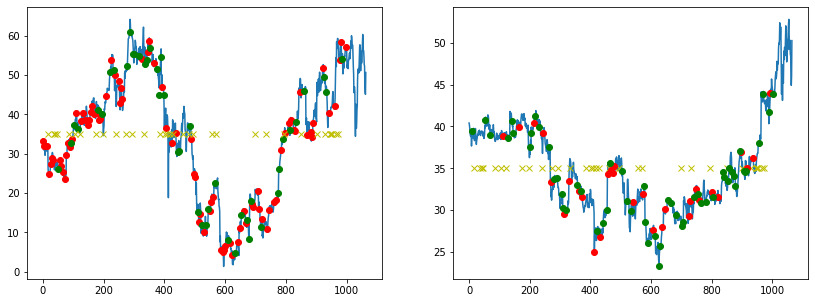

In [43]:
plt.figure(1, figsize=(14,5))
apl = plt.subplot(121)
msf = plt.subplot(122)
apl.plot(range(0, len(apl_open)), apl_open)
msf.plot(range(0, len(msf_open)), msf_open)
apl.plot(ba_action_times, bought_apl_at, "ro")
apl.plot(sa_action_times, sold_apl_at, "go")
apl.plot(n_action_times, nothing_at, "yx")
msf.plot(n_action_times, nothing_at, "yx")
msf.plot(bm_action_times, bought_msf_at, "ro")
msf.plot(sm_action_times, sold_msf_at, "go")

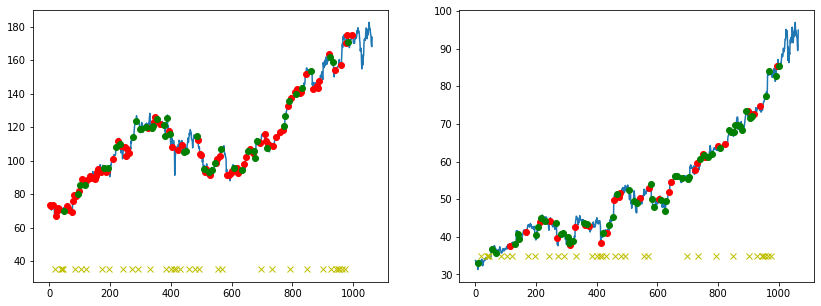

In [40]:
plt.figure(1, figsize=(14,5))
apl = plt.subplot(121)
msf = plt.subplot(122)
apl.plot(range(0, len(apl_open_orig)), apl_open_orig)
msf.plot(range(0, len(msf_open_orig)), msf_open_orig)
apl.plot(ba_action_times, bought_apl_at_orig, "ro")
apl.plot(sa_action_times, sold_apl_at_orig, "go")
apl.plot(n_action_times, nothing_at, "yx")
msf.plot(n_action_times, nothing_at, "yx")
msf.plot(bm_action_times, bought_msf_at_orig, "ro")
msf.plot(sm_action_times, sold_msf_at_orig, "go")